# Pyro Example

Starting from https://github.com/swbg/pyro-hackers/blob/main/notebooks/chapter_02.ipynb

In [1]:
import numpy as np
import pyro
import pyro.distributions as dist
import requests
import torch
from pyro.infer import MCMC, NUTS
from pyro.infer.predictive import Predictive
import pandas as pd
import seaborn as sns

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter2_MorePyMC/data/challenger_data.csv')

In [3]:
data = data.dropna()

In [4]:
data['Damage Incident'] = data['Damage Incident'].replace({'Challenger Accident': 1}).astype(int)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24 entries, 0 to 24
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Date             24 non-null     object
 1   Temperature      24 non-null     int64 
 2   Damage Incident  24 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 768.0+ bytes


In [6]:
temperatures = torch.tensor(data['Temperature'], dtype=torch.float64)
failures = torch.tensor(data['Damage Incident'], dtype=torch.float64)

In [7]:
def challenger_model(temperatures, failures):
    alpha = pyro.sample("alpha", dist.Normal(0, 10))
    beta = pyro.sample("beta", dist.Normal(0, 10))

    logits = alpha + beta * temperatures

    with pyro.plate("plate", temperatures.shape[0]):
        pyro.sample("failures", dist.Bernoulli(logits=logits), obs=failures)

In [38]:
pyro.render_model(challenger_model, (temperatures, failures))

ImportError: Looks like you want to use graphviz (https://graphviz.org/) to render your model. You need to install `graphviz` to be able to use this feature. It can be installed with `pip install graphviz`.

In [8]:
nuts_kernel = NUTS(challenger_model)

In [9]:
mcmc = MCMC(nuts_kernel, num_samples=2000, warmup_steps=400)
mcmc.run(temperatures, failures)

Sample: 100%|████████████████████████████████████████| 2400/2400 [00:28, 84.44it/s, step size=5.35e-02, acc. prob=0.952]                                                                                    


In [10]:
mcmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}
mcmc_samples = pd.DataFrame(mcmc_samples)
mcmc_samples.head()

,alpha,beta
0,11.628547,-0.176533
1,11.730321,-0.188868
2,11.920421,-0.196618
3,16.690276,-0.267273
4,17.007251,-0.253921


array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'beta'}>]], dtype=object)

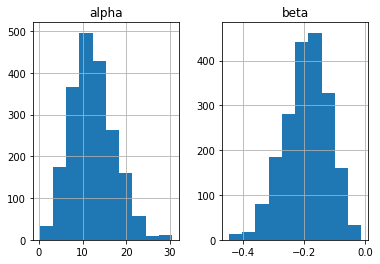

In [11]:
mcmc_samples.hist()

In [12]:
mcmc_samples.mean()

alpha    12.291793
beta     -0.192398
dtype: float64

In [14]:
mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha     12.29      4.90     11.87      4.41     20.29       nan      1.00
      beta     -0.19      0.07     -0.19     -0.31     -0.08       nan      1.00

Number of divergences: 0


/Users/spencerbarton/Library/Caches/pypoetry/virtualenvs/bayesian-function-fit-qdzAiiby-py3.9/lib/python3.9/site-packages/pyro/infer/mcmc/util.py:498: UserWarning: Traceback (most recent call last):
  File "/Users/spencerbarton/Library/Caches/pypoetry/virtualenvs/bayesian-function-fit-qdzAiiby-py3.9/lib/python3.9/site-packages/pyro/infer/mcmc/util.py", line 496, in wrapped
    val = fn(sample, *args, **kwargs)
  File "/Users/spencerbarton/Library/Caches/pypoetry/virtualenvs/bayesian-function-fit-qdzAiiby-py3.9/lib/python3.9/site-packages/pyro/ops/stats.py", line 189, in effective_sample_size
    gamma_k_c = autocovariance(input, dim=0)  # N x C x sample_shape
  File "/Users/spencerbarton/Library/Caches/pypoetry/virtualenvs/bayesian-function-fit-qdzAiiby-py3.9/lib/python3.9/site-packages/pyro/ops/stats.py", line 137, in autocovariance
    return autocorrelation(input, dim) * input.var(dim, unbiased=False, keepdim=True)
  File "/Users/spencerbarton/Library/Caches/pypoetry/virtualenvs/bay

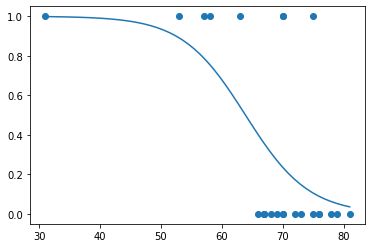

In [23]:
import matplotlib.pyplot as plt
import numpy as np

_, ax = plt.subplots()
ax.scatter(
  x=data['Temperature'],
  y=data['Damage Incident'],
)

temps = np.linspace(data['Temperature'].min(), data['Temperature'].max())
means = mcmc_samples.mean()
alpha = means['alpha'] 
beta = means['beta']
logit = beta * temps + alpha
curve = 1 / (1 + np.exp(-logit))

plt.plot(temps, curve)

In [30]:
predictor = Predictive(challenger_model, mcmc.get_samples(), return_sites=["alpha", "beta"], parallel=True)

new_temperatures = torch.linspace(25, 85, 100)
new_samples = predictor.get_samples(new_temperatures, None)
new_logits = new_samples["alpha"] + new_samples["beta"] * new_temperatures
new_probs = 1 / (1 + torch.exp(-new_logits))

new_probs

tensor([[0.9993, 0.9992, 0.9991,  ..., 0.0406, 0.0366, 0.0330],
        [0.9991, 0.9990, 0.9989,  ..., 0.0164, 0.0146, 0.0131],
        [0.9991, 0.9990, 0.9988,  ..., 0.0104, 0.0093, 0.0082],
        ...,
        [1.0000, 1.0000, 1.0000,  ..., 0.0030, 0.0025, 0.0021],
        [1.0000, 1.0000, 1.0000,  ..., 0.0032, 0.0027, 0.0022],
        [1.0000, 1.0000, 1.0000,  ..., 0.0016, 0.0013, 0.0011]],
       dtype=torch.float64)

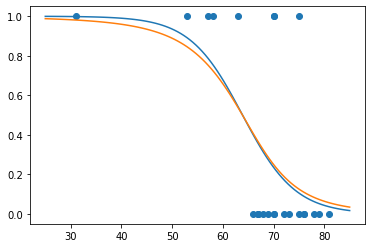

In [36]:
_, ax = plt.subplots()
ax.scatter(
  x=data['Temperature'],
  y=data['Damage Incident'],
)

means = mcmc_samples.mean()
alpha = means['alpha'] 
beta = means['beta']
logit = beta * new_temperatures.numpy() + alpha
curve = 1 / (1 + np.exp(-logit))

plt.plot(new_temperatures, curve)

plt.plot(new_temperatures, new_probs.mean(axis=0))